In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import torch
import re


from nnood.paths import default_plans_identifier, raw_data_base, results_base
from nnood.utils.file_operations import load_results_json

def get_results(dataset, task, plans_identifier):
    result_metrics = load_results_json(dataset, task, plans_identifier)['results']
    return result_metrics

In [2]:
m_dset_name = 'chestXray14_PA_male'
f_dset_name = 'chestXray14_PA_female'

tasks = ['FPI', 'CutPaste', 'PII', 'NSA', 'NSAMixed']
renamed_tasks = [re.sub('OpenCV', '', t) for t in tasks]
datasets = [m_dset_name, f_dset_name]
metrics = ['AUROC', 'AP score']

In [10]:
results = []

for dset in datasets:

    for t in tasks:
        try:
            curr_res = get_results(dset, t, default_plans_identifier)
            results.append([curr_res[m] for m in metrics])
        except:
            results.append([0.0 for m in metrics])

results = np.array(results)
results = results.T
    

In [11]:
micolumns = pd.MultiIndex.from_product([datasets, renamed_tasks], names=['Dataset', 'Task'])

results_df = pd.DataFrame(results, index=metrics, columns=micolumns)
results_df


Dataset  chestXray14_PA_male                                          \
Task                     FPI  CutPaste       PII       NSA  NSAMixed   
AUROC               0.514639  0.483930  0.554185  0.718229  0.713586   
AP score            0.074911  0.071328  0.083672  0.161986  0.167294   

Dataset  chestXray14_PA_female                                          
Task                       FPI  CutPaste       PII       NSA  NSAMixed  
AUROC                 0.490442  0.446458  0.614689  0.698809  0.697537  
AP score              0.063814  0.060164  0.086286  0.139279  0.133396

In [12]:
print(results_df.round(3).to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
Dataset & \multicolumn{5}{l}{chestXray14\_PA\_male} & \multicolumn{5}{l}{chestXray14\_PA\_female} \\
Task &                 FPI & CutPaste &    PII &    NSA & NSAMixed &                   FPI & CutPaste &    PII &    NSA & NSAMixed \\
\midrule
AUROC    &               0.515 &    0.484 &  0.554 &  0.718 &    0.714 &                 0.490 &    0.446 &  0.615 &  0.699 &    0.698 \\
AP score &               0.075 &    0.071 &  0.084 &  0.162 &    0.167 &                 0.064 &    0.060 &  0.086 &  0.139 &    0.133 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_856096/2842510611.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_df.round(3).to_latex())


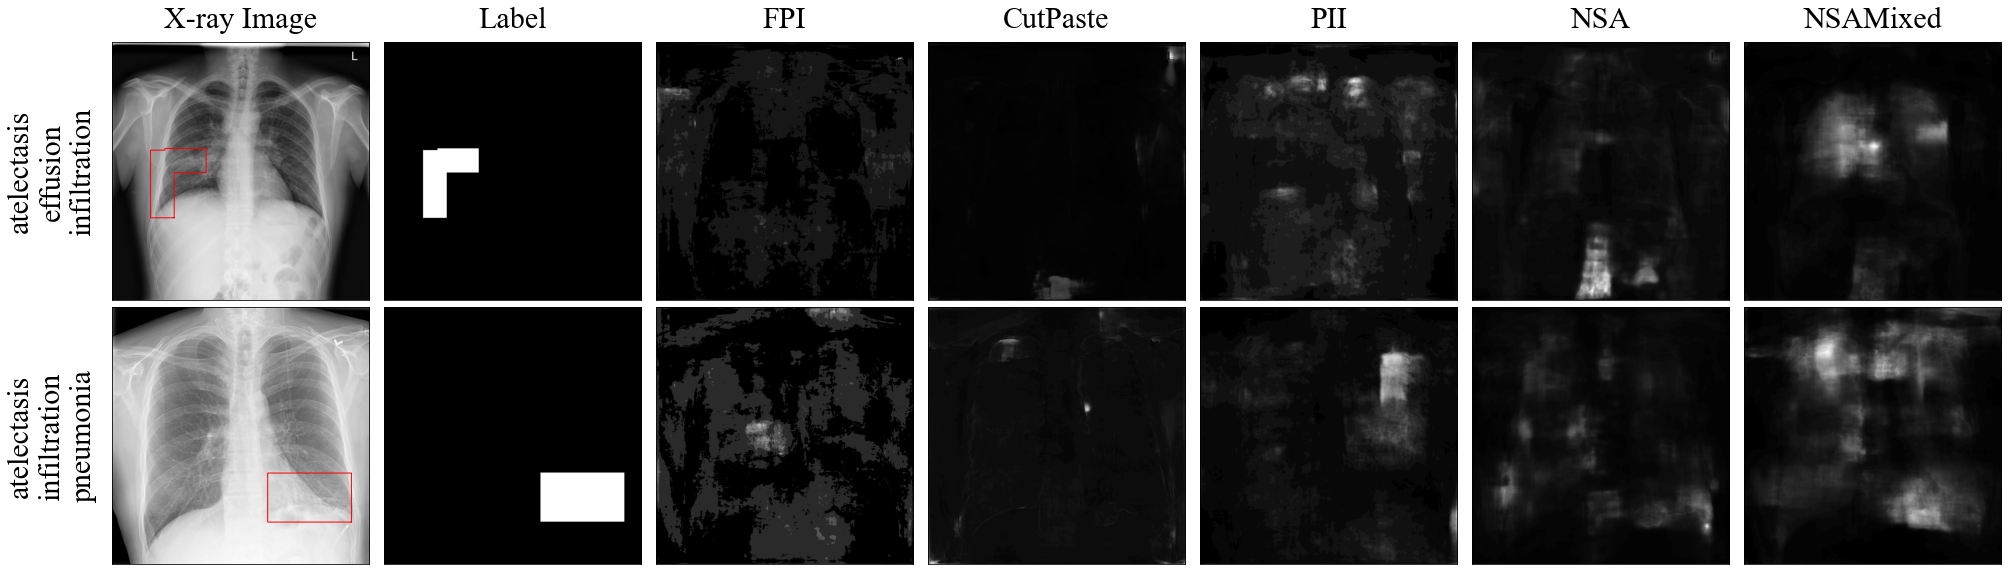

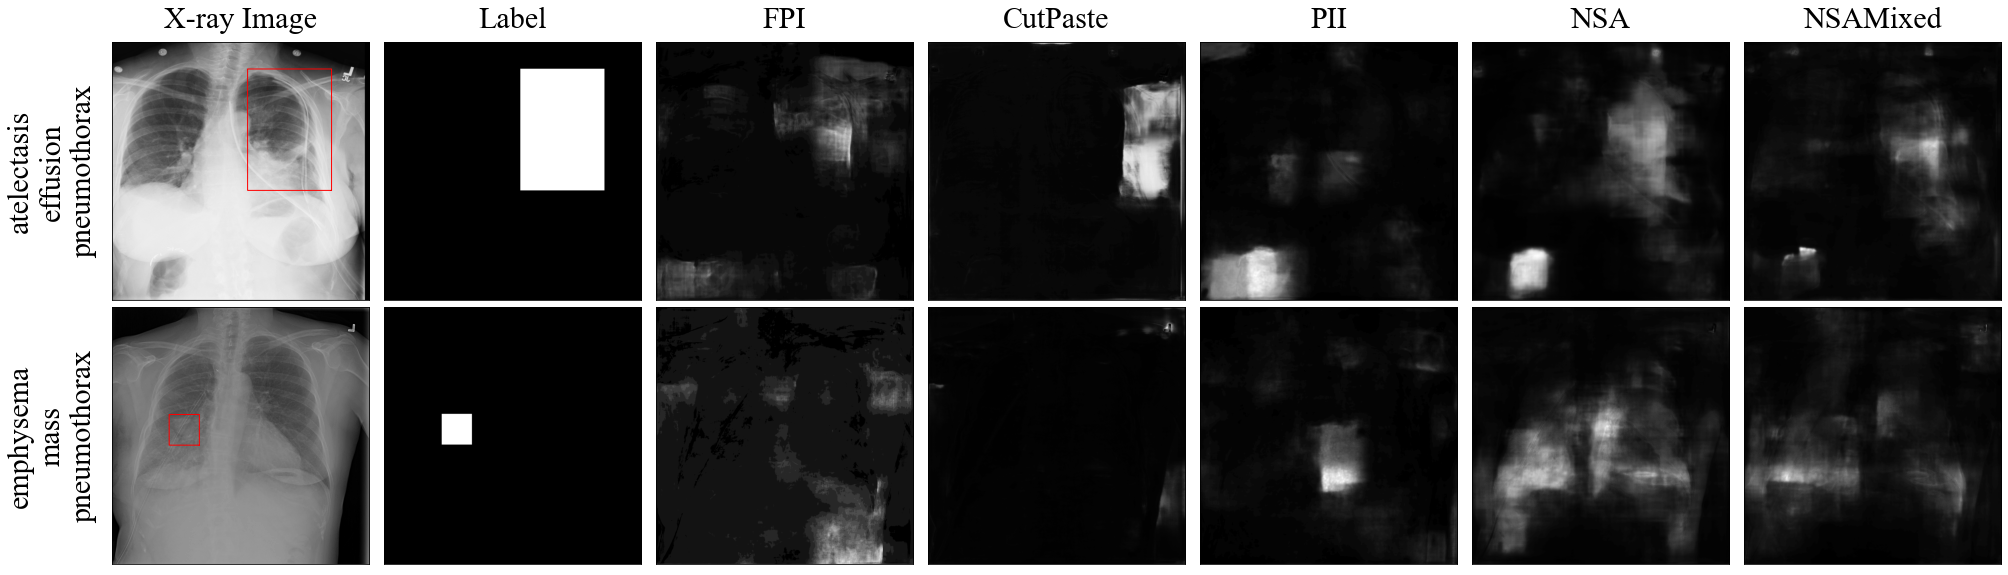

In [13]:
from skimage import measure

m_fnames = ['00014447_004.png', '00014197_010.png']
m_labels = ['atelectasis\neffusion\ninfiltration', 'atelectasis\ninfiltration\npneumonia']

f_fnames = ['00007471_003.png', '00029105_015.png', ]
f_labels = ['atelectasis\neffusion\npneumothorax', 'emphysema\nmass\npneumothorax']

examples = [(m_dset_name, m_fnames, m_labels), (f_dset_name, f_fnames, f_labels)]

ax_row_params = {'fontsize': 30, 'fontname': 'Times New Roman', 'labelpad': 15}
ax_title_params = {'fontsize': 30, 'fontname': 'Times New Roman', 'pad': 15}

for dset_name, fnames, labels in examples:
    
    sample_ids = [s.split('.')[0] for s in fnames]

    ex_img_folder = Path(raw_data_base, dset_name, 'imagesTs')
    ex_label_folder = Path(raw_data_base, dset_name, 'labelsTs')
    ex_pred_folder = Path(results_base, dset_name) 
    
    num_rows = len(fnames)
    num_cols = len(tasks) + 2
    
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows), sharex=True, sharey=True)
    
    # display images
    for i in range(num_rows):
        
        ax[i,0].imshow(cv2.imread((ex_img_folder / (sample_ids[i] + '_0000.png')).__str__(), cv2.IMREAD_GRAYSCALE), cmap='gray')
        ax[i,0].set_ylabel(labels[i],**ax_row_params)
        
        label_mask = cv2.imread((ex_label_folder / fnames[i]).__str__(), cv2.IMREAD_GRAYSCALE)
        anomaly_contours = measure.find_contours(label_mask)
        
        for a_c in anomaly_contours:
            ax[i,0].plot(a_c[:, 1], a_c[:, 0], linewidth=1, color='red')
        
        ax[i,1].imshow(label_mask, cmap='gray')
        
        
        for j in range(len(tasks)):
            try:
                ax[i, j + 2].imshow(cv2.imread((ex_pred_folder / tasks[j] / 'testResults' / default_plans_identifier / fnames[i]).__str__(), cv2.IMREAD_GRAYSCALE), cmap='gray')
            except:
                print('Missing ', sample_ids[i], tasks[j]) 
                
    
    ax[0,0].set_title('X-ray Image', **ax_title_params)
    ax[0,1].set_title('Label', **ax_title_params)
    
    for j in range(len(tasks)):
        ax[0, j + 2].set_title(renamed_tasks[j], **ax_title_params)
    
    # set layouts
    for axi in ax.ravel():
        axi.set_xticks([])
        axi.set_yticks([])
    
    fig.tight_layout()
    
    #fig.savefig(dset_name + '_example_visualisations.pdf')
    fig.show()



In [14]:
train_times = {}

for dset_name in datasets:
    print('For dataset ', dset_name)
    
    train_times[dset_name] = {}
    
    dset_pred_folder = Path(results_base, dset_name) 
    for t in tasks:
        
        try :
            train_epochs = []
            for i in range(5):
                training_data = torch.load(dset_pred_folder / t / 'fullres'/ ('nnOODTrainerDS__' + default_plans_identifier) / f'fold_{i}' / 'model_final_checkpoint.model', map_location=torch.device('cpu'))
                train_epochs.append(training_data['epoch'])

            print('For task: ', t)
            print('Train length in epochs: ', train_epochs)
            print('Average train length: ', np.mean(train_epochs))
            print()
            train_times[dset_name][t] = (train_epochs, np.mean(train_epochs))
        except:
            print('Missing for ', dset_name, t)
                                       

For dataset  chestXray14_PA_male
For task:  FPI
Train length in epochs:  [95, 144, 242, 186, 155]
Average train length:  164.4

For task:  CutPaste
Train length in epochs:  [22, 28, 26, 25, 34]
Average train length:  27.0

For task:  PII
Train length in epochs:  [321, 142, 160, 319, 273]
Average train length:  243.0

For task:  NSA
Train length in epochs:  [88, 92, 71, 82, 78]
Average train length:  82.2

For task:  NSAMixed
Train length in epochs:  [221, 117, 104, 95, 112]
Average train length:  129.8

For dataset  chestXray14_PA_female
For task:  FPI
Train length in epochs:  [361, 258, 195, 541, 548]
Average train length:  380.6

For task:  CutPaste
Train length in epochs:  [30, 29, 26, 28, 25]
Average train length:  27.6

For task:  PII
Train length in epochs:  [611, 212, 206, 691, 192]
Average train length:  382.4

For task:  NSA
Train length in epochs:  [105, 95, 105, 112, 57]
Average train length:  94.8

For task:  NSAMixed
Train length in epochs:  [100, 133, 101, 135, 79]
Averag

In [15]:
for t in tasks:
    print(t, np.mean([train_times[d][t][1] for d in datasets if t in train_times[d].keys()]))




FPI 272.5
CutPaste 27.3
PII 312.7
NSA 88.5
NSAMixed 119.7
